In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR

In [7]:
stocks_data = pd.read_csv("/Users/ananyaagarwal/Desktop/dev_cohort/HistoricStock_Forecasting/stocks.csv")
print(stocks_data.head())

  Ticker        Date        Open        High         Low       Close  \
0   AAPL  2023-02-07  150.639999  155.229996  150.639999  154.649994   
1   AAPL  2023-02-08  153.880005  154.580002  151.169998  151.919998   
2   AAPL  2023-02-09  153.779999  154.330002  150.419998  150.869995   
3   AAPL  2023-02-10  149.460007  151.339996  149.220001  151.009995   
4   AAPL  2023-02-13  150.949997  154.259995  150.919998  153.850006   

    Adj Close    Volume  
0  154.414230  83322600  
1  151.688400  64120100  
2  150.639999  56007100  
3  151.009995  57450700  
4  153.850006  62199000  


In [8]:
#Check for missing values in the dataset
stocks_data['Date'] = pd.to_datetime(stocks_data['Date'])
missing_values = stocks_data.isnull().sum()
unique_stocks = stocks_data['Ticker'].value_counts()
print(missing_values)

print(unique_stocks)

Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
AAPL    62
MSFT    62
NFLX    62
GOOG    62
Name: Ticker, dtype: int64


In [9]:
#Check the time range of the dataset
time_range = stocks_data['Date'].min(), stocks_data['Date'].max()
print(time_range)

(Timestamp('2023-02-07 00:00:00'), Timestamp('2023-05-05 00:00:00'))


/var/folders/qv/lxq7fjkn3d14p_gmp187lv6w0000gn/T/ipykernel_14145/1543332757.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


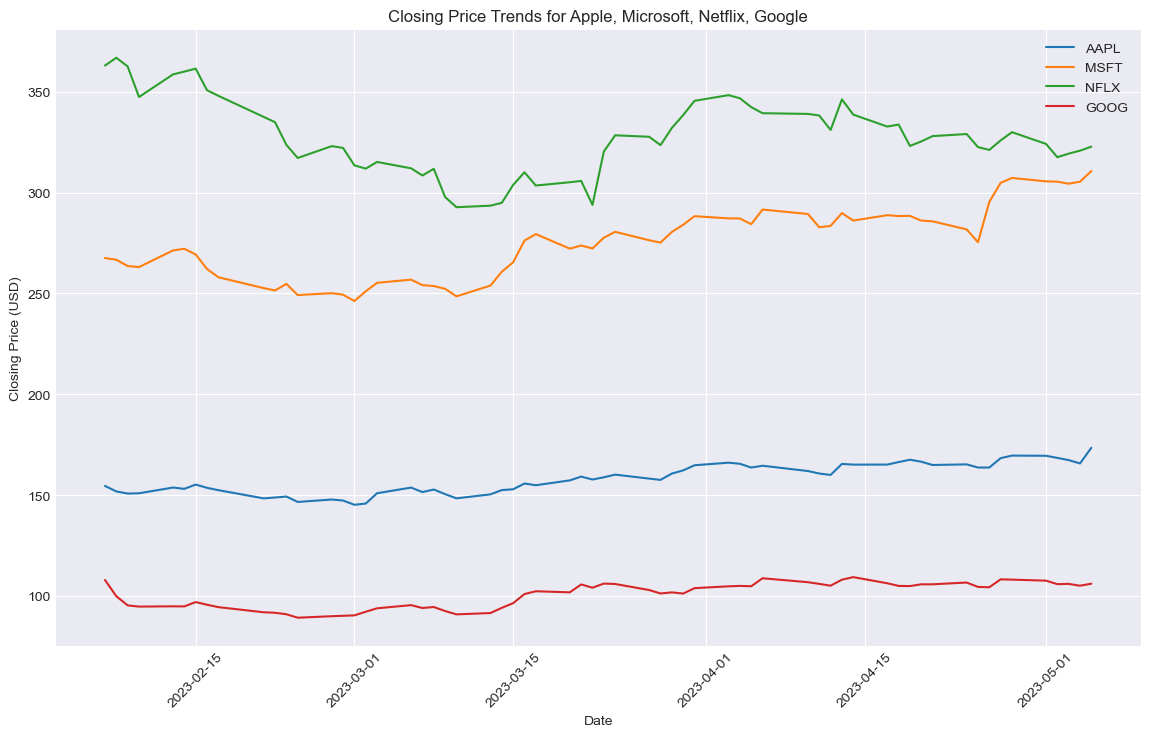

In [10]:
plt.style.use('seaborn-darkgrid')

fig, ax = plt.subplots(figsize=(14, 8))

for ticker in unique_stocks.index:
    subset = stocks_data[stocks_data['Ticker'] == ticker]
    ax.plot(subset['Date'], subset['Close'], label=ticker)

ax.set_title('Closing Price Trends for Apple, Microsoft, Netflix, Google')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')
ax.legend()

plt.xticks(rotation=45)
plt.show()

Below code checks whether trends are stationary or not, if they aren't stationary, we need to convert them to make it stationary.

In [11]:
# function to perform Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'ADF Test on "{title}"')
    result = adfuller(series, autolag='AIC')  # ADF test
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)

    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string()) 
    print('\n')

# perform ADF test on the 'Close' price of each stock
for ticker in unique_stocks.index:
    series = stocks_data[stocks_data['Ticker'] == ticker]['Close']
    adf_test(series, title=ticker)

ADF Test on "AAPL"
ADF Test Statistic             -0.291693
p-value                         0.926673
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745


ADF Test on "MSFT"
ADF Test Statistic             -0.149807
p-value                         0.944246
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745


ADF Test on "NFLX"
ADF Test Statistic             -2.150926
p-value                         0.224536
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745


ADF Test on "GOOG"
ADF Test Statistic             -1.431504
p-value         

In [12]:
# differencing the 'Close' price of each stock to make the series stationary
stocks_data['Diff_Close'] = stocks_data.groupby('Ticker')['Close'].transform(lambda x: x.diff())

for ticker in unique_stocks.index:
    series = stocks_data[stocks_data['Ticker'] == ticker]['Diff_Close'].dropna()
    adf_test(series, title=f"{ticker} - Differenced")

ADF Test on "AAPL - Differenced"
ADF Test Statistic             -5.238104
p-value                         0.000007
#Lags Used                      4.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137


ADF Test on "MSFT - Differenced"
ADF Test Statistic            -5.895024e+00
p-value                        2.864876e-07
#Lags Used                     1.000000e+00
Number of Observations Used    5.900000e+01
Critical Value (1%)           -3.546395e+00
Critical Value (5%)           -2.911939e+00
Critical Value (10%)          -2.593652e+00


ADF Test on "NFLX - Differenced"
ADF Test Statistic            -8.022480e+00
p-value                        2.058613e-12
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.59319

In [14]:
# prepare the dataset for VAR model
var_data = stocks_data.pivot(index='Date', columns='Ticker', values='Diff_Close').dropna()

model = VAR(var_data)
model_fitted = model.fit(ic='aic')

forecast_steps = 5

forecasted_values = model_fitted.forecast(var_data.values[-model_fitted.k_ar:], steps=forecast_steps)

forecasted_df = pd.DataFrame(forecasted_values, index=pd.date_range(start=var_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), columns=var_data.columns)

for column in forecasted_df.columns:
    forecasted_df[column] = (stocks_data.groupby('Ticker')['Close'].last()[column] + forecasted_df[column].cumsum())

print(forecasted_df)

Ticker            AAPL        GOOG        MSFT        NFLX
2023-05-06  174.369001  113.624024  320.179608  327.604320
2023-05-07  169.684437  104.915080  318.416783  342.704109
2023-05-08  168.190894  107.828473  329.210732  367.542312
2023-05-09  160.836027   99.287041  326.849012  348.088074
2023-05-10  167.645928  101.392914  317.986680  387.059442


/Users/ananyaagarwal/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


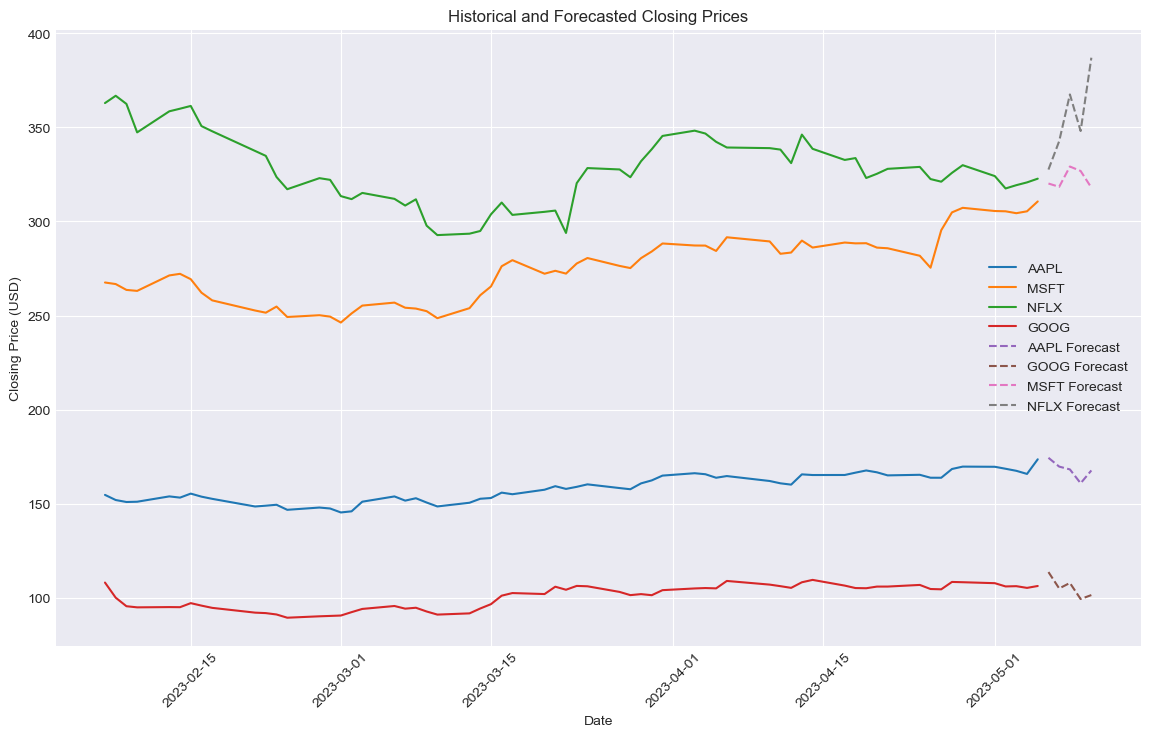

In [15]:
fig, ax = plt.subplots(figsize=(14, 8))

# plot historical closing prices for each stock
for ticker in unique_stocks.index:
    historical_data = stocks_data[stocks_data['Ticker'] == ticker]
    ax.plot(historical_data['Date'], historical_data['Close'], label=ticker)

# plot the forecasted closing prices
for column in forecasted_df.columns:
    ax.plot(forecasted_df.index, forecasted_df[column], label=f'{column} Forecast', linestyle='--')

ax.set_title('Historical and Forecasted Closing Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')
ax.legend()

plt.xticks(rotation=45)
plt.show()

We have used data of 3 months from companies Apple, Microsoft, Netflix and Google to along with their forecasted stock price for the next 5 days stack change.